In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import chi2_contingency
import h2o
from h2o.estimators import H2OXGBoostEstimator
from h2o.grid.grid_search import H2OGridSearch
import shap
%matplotlib inline

In [57]:
import shap

# Objective:
 * Identify appropriate features and model configuration to use in order to optimize our ability to predict the outcome of whether a given customer will subscribe to a term deposit
 
# Approach
 * Use of Exploratory Data Analysis
     * Data Visualizations
     * Two Sample T-Test: Categorical vs Numeric relationship
     * Chi-Square Test: Categorical vs Categorical relationship
 * Modeling
     * XGBoost model; use of both training & validation data sets 
     * Feature Selection based on relative importance from trained model
     * Model tuned through use of grid search against validation data set
     * Model performance evaluated based on Precision, Recall, and AUC

# Data
The data set for the following problem can be found here; https://www.kaggle.com/datasets/henriqueyamahata/bank-marketing. An outline of what each feature represents is listed below.
 * __Bank client data:__
     * Age (numeric)
     * Job : type of job (categorical: 'admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown')
     * Marital : marital status (categorical: 'divorced', 'married', 'single', 'unknown' ; note: 'divorced' means divorced or widowed)
     * Education (categorical: 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate', 'professional.course', 'university.degree', 'unknown')
     * Default: has credit in default? (categorical: 'no', 'yes', 'unknown')
     * Housing: has housing loan? (categorical: 'no', 'yes', 'unknown')
     * Loan: has personal loan? (categorical: 'no', 'yes', 'unknown')
 * __Related with the last contact of the current campaign:__
     * Contact: contact communication type (categorical:'cellular','telephone')
     * Month: last contact month of year (categorical: 'jan', 'feb', 'mar', …, 'nov', 'dec')
     * Dayofweek: last contact day of the week (categorical:'mon','tue','wed','thu','fri')
     * Duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
 * __Other attributes:__
     * Campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
     * Pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
     * Previous: number of contacts performed before this campaign and for this client (numeric)
     * Poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
 * __Social and economic context attributes__
     * Emp.var.rate: employment variation rate - quarterly indicator (numeric)
     * Cons.price.idx: consumer price index - monthly indicator (numeric)
     * Cons.conf.idx: consumer confidence index - monthly indicator (numeric)
     * Euribor3m: euribor 3 month rate - daily indicator (numeric)
     * Nr.employed: number of employees - quarterly indicator (numeric)
 * __Output variable (desired target):__
     * y - has the client subscribed a term deposit? (binary: 'yes', 'no')

In [2]:
df = pd.read_csv('./bank-additional-full.csv')
df["y"] = df["y"].astype(int)
df['count'] = 1
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,count
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,1
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,1
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,1
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,1
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,1


In [3]:
df['y'].mean()

0.11265417111780131

In [4]:
print(df.isnull().sum())

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
count             0
dtype: int64


## Evaluate relationship between Numeric inputs and Binary Target Variable
Based on our results below it appears that Age, Duration, and P Days Bin are relevant

In [5]:
df.describe()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,count
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.0
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.112654,1.0
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,0.316173,0.0
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000,1.0
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000,1.0
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000,1.0
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000,1.0
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000,1.0


(array([  635.,  1423.,  1243.,     0.,  1663.,  8534.,     0.,     0.,
        11456., 16234.]),
 array([4963.6 , 4990.05, 5016.5 , 5042.95, 5069.4 , 5095.85, 5122.3 ,
        5148.75, 5175.2 , 5201.65, 5228.1 ]),
 <a list of 10 Patch objects>)

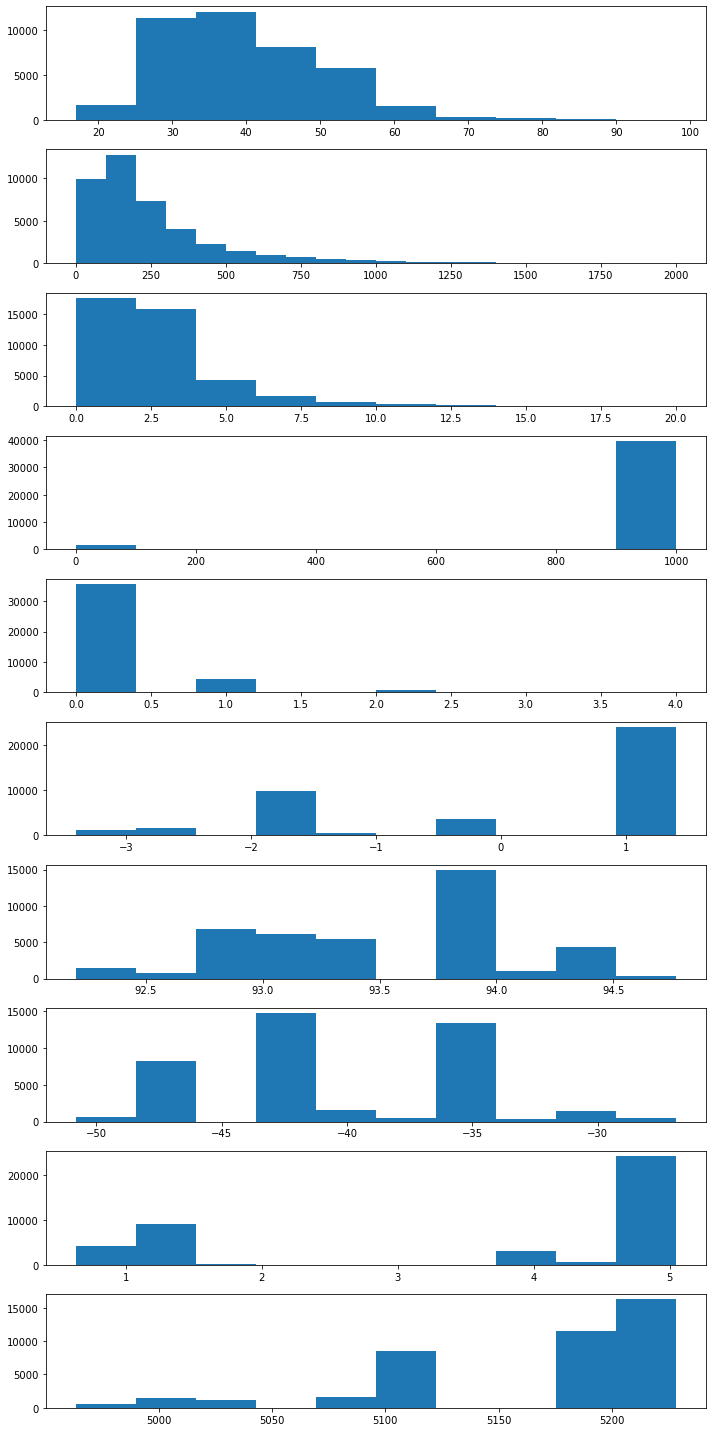

In [6]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(10,1, tight_layout=True, figsize=(10, 20))# , sharey=True

axs[0].hist(df['age'].dropna(), bins=10) #, range=[0,10]
axs[1].hist(df['duration'].dropna(), bins=20, range=[0,2000]) #
axs[2].hist(df['campaign'].dropna(), bins=10, range=[0,20]) #
axs[3].hist(df['pdays'].dropna(), bins=10) #
axs[4].hist(df['previous'].dropna(), bins=10, range=[0,4]) #, range=[0,10]
axs[5].hist(df['emp_var_rate'].dropna(), bins=10) #, range=[0,10]
axs[6].hist(df['cons_price_idx'].dropna(), bins=10) #, range=[0,10]
axs[7].hist(df['cons_conf_idx'].dropna(), bins=10) #, range=[0,10]
axs[8].hist(df['euribor3m'].dropna(), bins=10) #, range=[0,10]
axs[9].hist(df['nr_employed'].dropna(), bins=10) #, range=[0,10]

In [7]:
numeric_cols = ['age', 'duration', 'campaign', 'pdays',
       'previous', 'emp_var_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed']

def continuous_eda_func(df, cols):
    
    for i in numeric_cols:
        max_thresh = np.percentile(df[i], 99)
        df = df[df[i]<max_thresh]
        temp_name = f'{i}_bin'
        df[temp_name] = pd.cut(df[i], 6)
        grouped_df = df.groupby(temp_name).agg({'y':'mean', 'count':'sum'})
        grouped_df.plot(kind='line', y='y', figsize=(10,4))
        grouped_df.plot(y='count', kind='bar', figsize=(10,4))
    
    return

<ipython-input-7-a63b9200e9cb>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[temp_name] = pd.cut(df[i], 6)


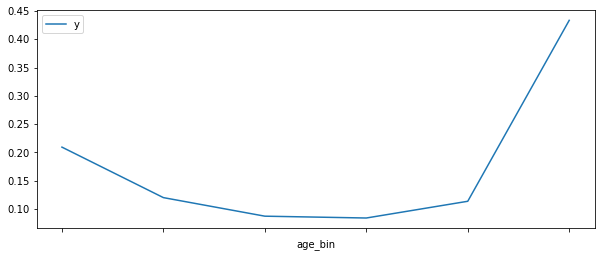

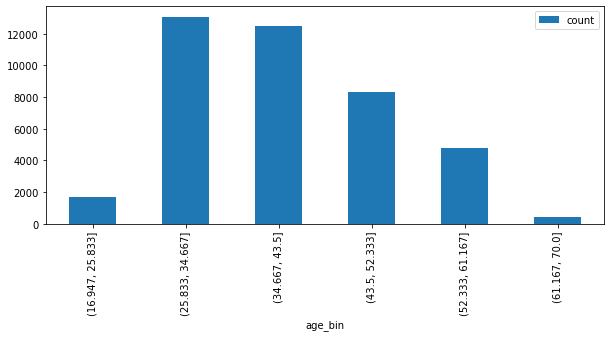

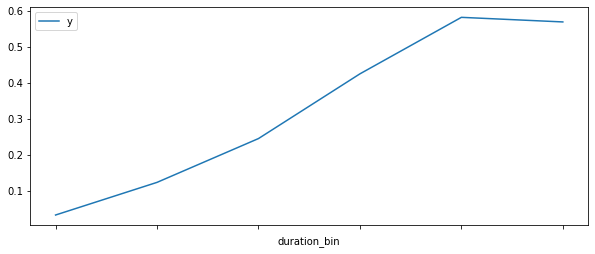

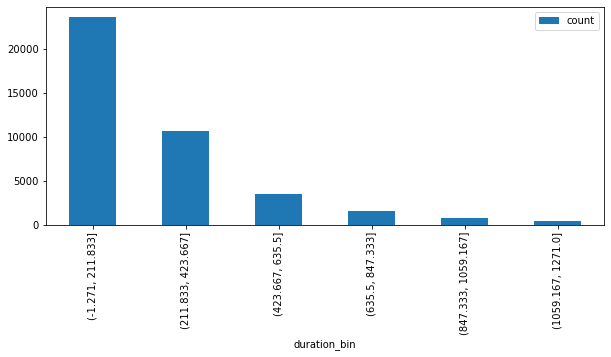

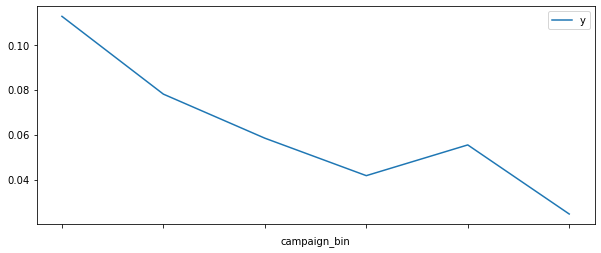

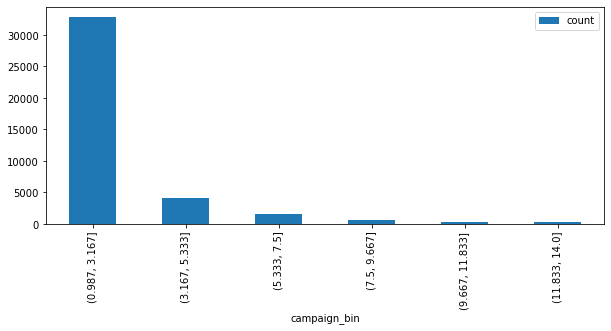

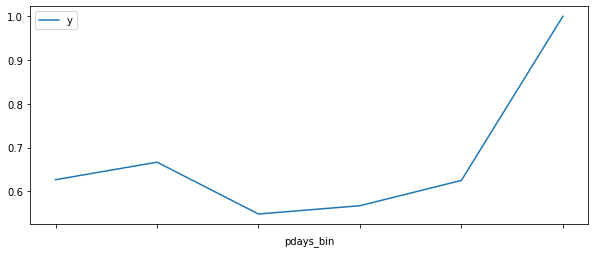

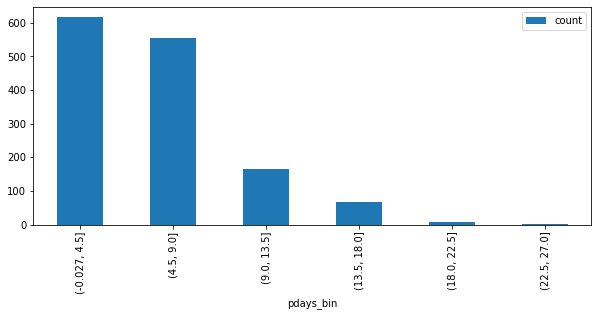

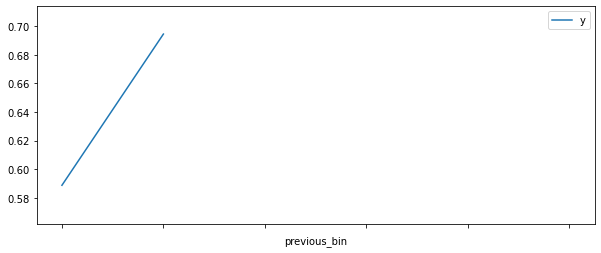

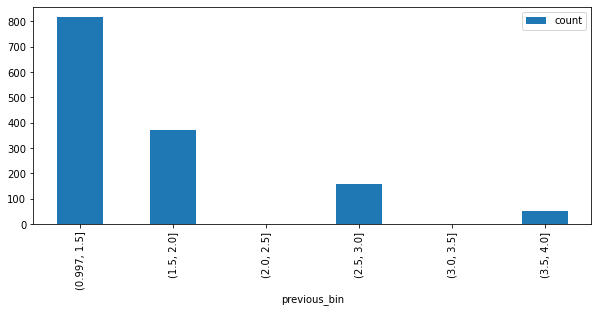

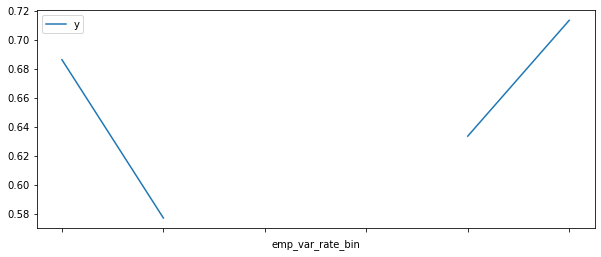

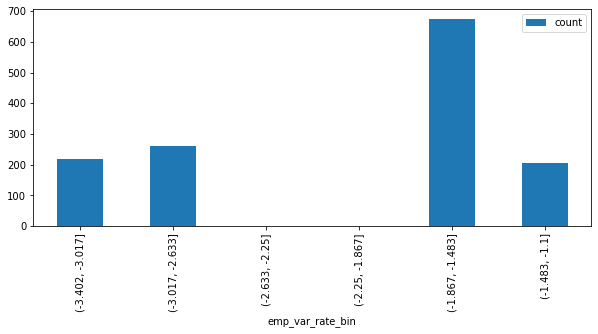

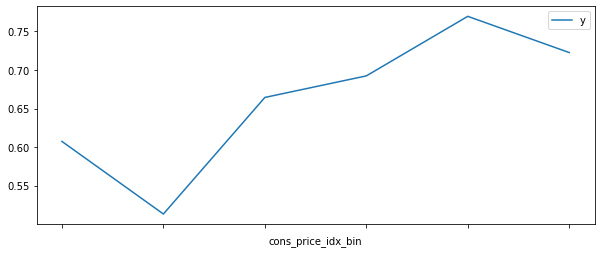

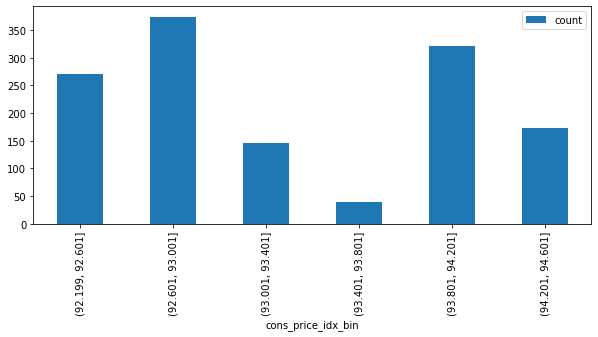

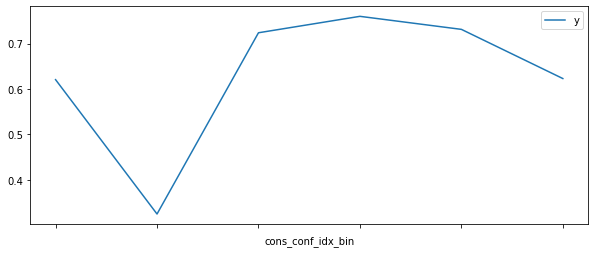

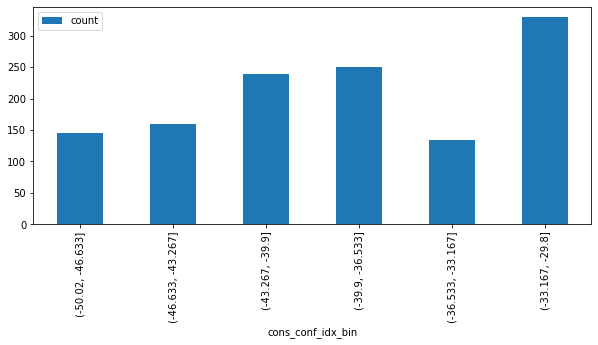

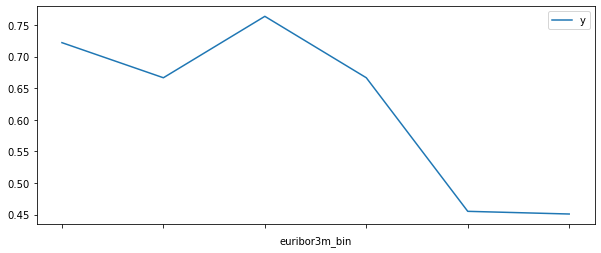

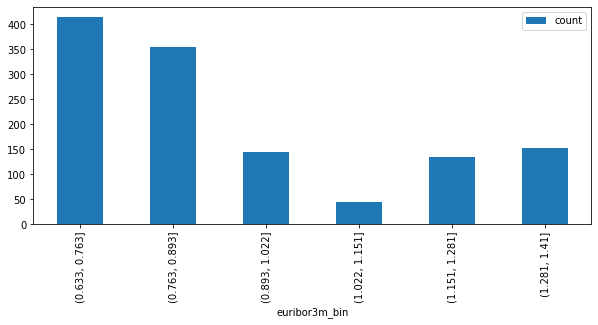

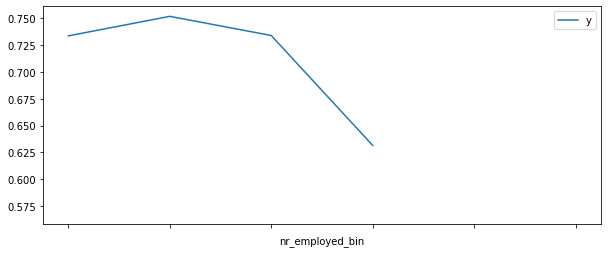

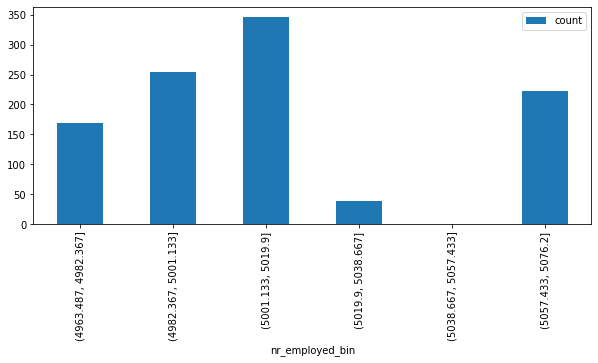

In [8]:
continuous_eda_func(df, numeric_cols)

In [9]:
numeric_cols = ['age', 'duration', 'campaign', 'pdays',
       'previous', 'emp_var_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed']

def boxplot_func(df, numeric_cols):
    df_yes = df[df['y']==1]
    df_no = df[df['y']==0]
    
    # Check to see that the variances of each group are not more than four times larger than their counterpart
    for i in numeric_cols:
        if (((np.var(df_yes[i]) / np.var(df_no[i])) > 0.25) &
            ((np.var(df_yes[i]) / np.var(df_no[i])) > 0.25)):
            print(f'{i} passes 4:1 variance ratio check')
        else:
            print(f'{i} DOES NOT pass the 4:1 variance ratio check')
        
        t, p = stats.ttest_ind(df_yes[i], df_no[i], equal_var=False)
        print("t-test score, max capacity: t = %.2f p = %.3f" % (t,p))
        alpha=0.05
        if p < alpha:
            print('Reject null hypothesis of equal variances')
        else:
            print('We cannot reject null hypothesis of identical variances')
        print("")
        
        # Values of pdays set to 999 represents cases where client was not previously contacted
        if i=='pdays':
            df[df['pdays']<999].boxplot(column=[i], by='y', rot=90)
        else:
            df.boxplot(column=[i], by='y', rot=90)
    
    return
        
    

age passes 4:1 variance ratio check
t-test score, max capacity: t = 4.78 p = 0.000
Reject null hypothesis of equal variances

duration passes 4:1 variance ratio check
t-test score, max capacity: t = 55.50 p = 0.000
Reject null hypothesis of equal variances

campaign passes 4:1 variance ratio check
t-test score, max capacity: t = -20.25 p = 0.000
Reject null hypothesis of equal variances

pdays passes 4:1 variance ratio check
t-test score, max capacity: t = -32.25 p = 0.000
Reject null hypothesis of equal variances

previous passes 4:1 variance ratio check
t-test score, max capacity: t = 28.13 p = 0.000
Reject null hypothesis of equal variances

emp_var_rate passes 4:1 variance ratio check
t-test score, max capacity: t = -59.14 p = 0.000
Reject null hypothesis of equal variances

cons_price_idx passes 4:1 variance ratio check
t-test score, max capacity: t = -24.08 p = 0.000
Reject null hypothesis of equal variances

cons_conf_idx passes 4:1 variance ratio check
t-test score, max capacit

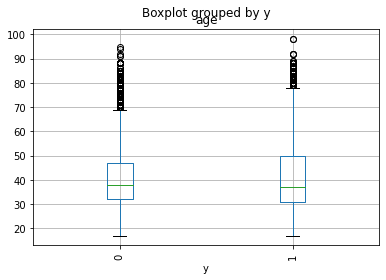

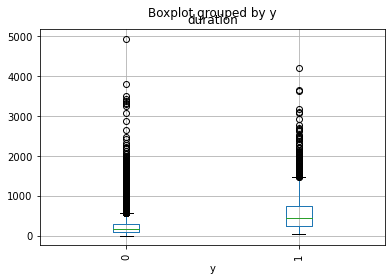

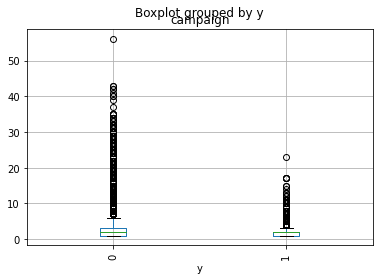

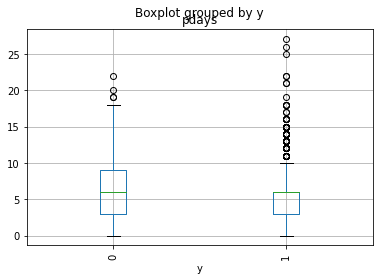

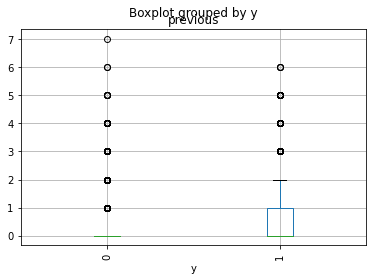

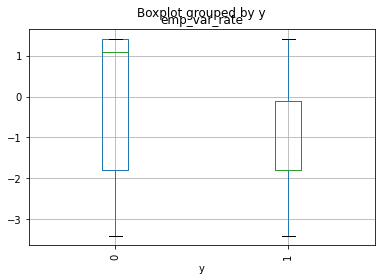

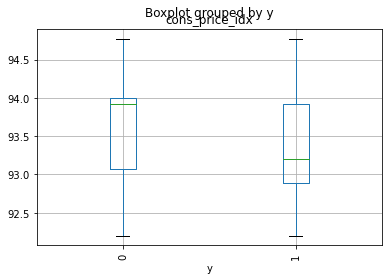

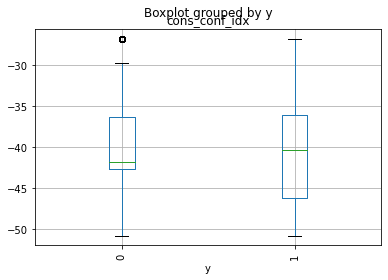

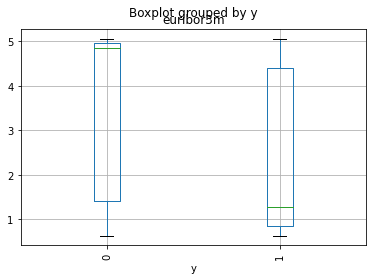

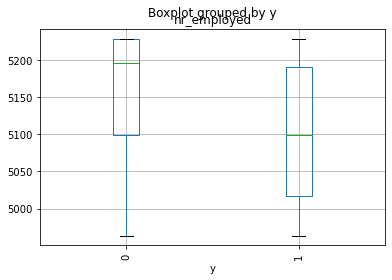

In [10]:
boxplot_func(df, numeric_cols)

## Evaluate relationship between Categorical inputs and Binary Target Variable

In [11]:
df.describe(include = 'object')

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563


### Define Function to Process Remaining Categorical Features

In [12]:
categorical_cols=['job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'poutcome']

def chi_square_eda(df):
    for i in categorical_cols:
        ct = pd.crosstab(df[i], df['y'])# , margins=True
        chi, pval, dof, exp = stats.chi2_contingency(ct)
        print(f'{i} has a P-Value of p = %.4f' % (pval))
    return

In [13]:
chi_square_eda(df)

job has a P-Value of p = 0.0000
marital has a P-Value of p = 0.0000
education has a P-Value of p = 0.0000
default has a P-Value of p = 0.0000
housing has a P-Value of p = 0.0583
loan has a P-Value of p = 0.5787
contact has a P-Value of p = 0.0000
month has a P-Value of p = 0.0000
day_of_week has a P-Value of p = 0.0000
poutcome has a P-Value of p = 0.0000


### We can investigate the following significant features further
 * job
 * marital
 * education
 * default
 * contact
 * month
 * day_of_week
 * poutcome

### Job
We find that students and retirees are more likely to open account when compared to others

In [14]:
ct = pd.crosstab(df['job'], df['y'])# , margins=True
chi, pval, dof, exp = stats.chi2_contingency(ct)

In [15]:
contigency_pct = pd.crosstab(df['job'], df['y'], normalize='index')
contigency_pct

y,0,1
job,,
admin.,0.870274,0.129726
blue-collar,0.931057,0.068943
entrepreneur,0.914835,0.085165
housemaid,0.900000,0.100000
management,0.887825,0.112175
retired,0.747674,0.252326
self-employed,0.895144,0.104856
services,0.918619,0.081381
student,0.685714,0.314286


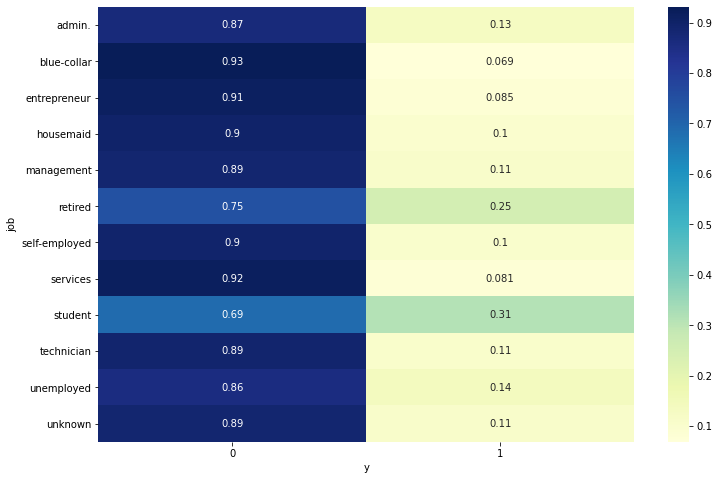

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

plt.figure(figsize=(12,8))
sns.heatmap(contigency_pct, annot=True, cmap="YlGnBu")

### Marital

In [17]:
ct = pd.crosstab(df['marital'], df['y'])# , margins=True
chi, pval, dof, exp = stats.chi2_contingency(ct)

In [18]:
contigency_pct = pd.crosstab(df['marital'], df['y'], normalize='index')
contigency_pct

y,0,1
marital,,
divorced,0.896791,0.103209
married,0.898427,0.101573
single,0.859959,0.140041
unknown,0.850000,0.150000


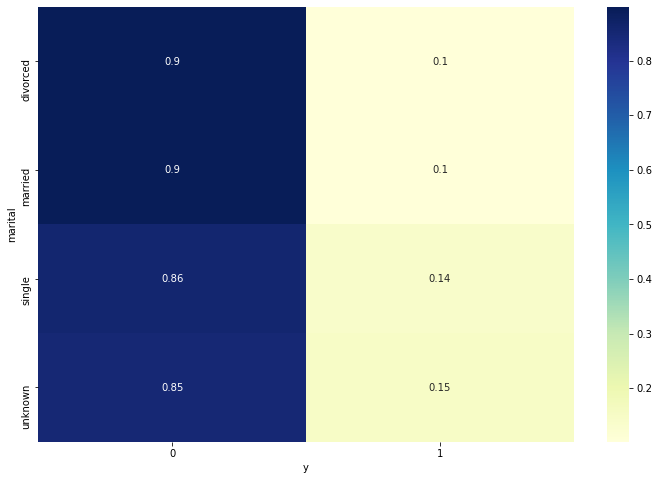

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

plt.figure(figsize=(12,8))
sns.heatmap(contigency_pct, annot=True, cmap="YlGnBu")

## Feature Selection - h2o Modeling

In [20]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,count
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,1
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,1
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,1
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,1
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,1


In [21]:
h2o.init(nthreads=-1,max_mem_size='16g');

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "13.0.2" 2020-01-14; Java(TM) SE Runtime Environment (build 13.0.2+8); Java HotSpot(TM) 64-Bit Server VM (build 13.0.2+8, mixed mode, sharing)
  Starting server from /Users/carsonransford/opt/anaconda3/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/kf/mmspqgqd1t5_75k5ybvv6v040000gn/T/tmpw3zjuhpx
  JVM stdout: /var/folders/kf/mmspqgqd1t5_75k5ybvv6v040000gn/T/tmpw3zjuhpx/h2o_carsonransford_started_from_python.out
  JVM stderr: /var/folders/kf/mmspqgqd1t5_75k5ybvv6v040000gn/T/tmpw3zjuhpx/h2o_carsonransford_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,"1 year, 11 months and 12 days !!!"
H2O_cluster_name:,H2O_from_python_carsonransford_pd4r4v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,16 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"accepting new members, healthy"


In [22]:
!java -version

java version "13.0.2" 2020-01-14
Java(TM) SE Runtime Environment (build 13.0.2+8)
Java HotSpot(TM) 64-Bit Server VM (build 13.0.2+8, mixed mode, sharing)


In [23]:
def cols_numeric(frame):
    columns = ['age', 'campaign', 'pdays',
       'previous', 'emp_var_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed']
    for col in columns:
        frame[f"{col}"] = frame[f"{col}"].asnumeric()
    return frame

def cols_factor(frame):
    columns = ['job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'poutcome', 'y']
    for col in columns:
        frame[f"{col}"] = frame[f"{col}"].asfactor()
    return frame

In [24]:
hf = h2o.import_file('./bank-additional-full.csv')
hf = cols_numeric(hf)
hf = cols_factor(hf)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [25]:
hf = hf[:, ['age', 'campaign', 'pdays',
       'previous', 'emp_var_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'poutcome', 'y']]

In [26]:
train, test, valid = hf.split_frame(ratios=[.7, .15])

In [31]:
# predictors = ['job', 'marital', 'education', 'default', 'housing', 'loan',
#        'contact', 'month', 'day_of_week', 'poutcome', 'age', 'campaign', 'pdays',
#        'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']

predictors = ['poutcome', 'age', 'campaign', 'pdays',
       'emp_var_rate', 'cons_conf_idx', 'euribor3m', 'nr_employed']

response = 'y'

In [32]:
xgb_params = {'learn_rate': [0.05],
              'max_depth': [4, 6, 8],
              'ntrees': [100, 200, 300],
              'min_rows': [2, 5],
              'gamma': [0.05, 0.1],
              'sample_rate': [0.8, 0.9],
              'col_sample_rate': [0.8, 0.9]
              }

In [33]:
xgb_grid_banking = H2OXGBoostEstimator(
            stopping_rounds=50,
            stopping_metric="logloss",
            stopping_tolerance=1e-5,
            distribution="bernoulli",
            score_tree_interval = 5,
            seed=101
        )

In [34]:
xgb_grid1_banking = H2OGridSearch(model=xgb_grid_banking,
                          grid_id='xgb_grid_banking',
                          hyper_params=xgb_params,
                          parallelism=0)

In [35]:
xgb_grid1_banking.train(x=predictors
                , y=response
                , training_frame=train
                , validation_frame=valid)
xgb_grid1_banking.show()

xgboost Grid Build progress: |████████████████████████████████████████████| 100%
       col_sample_rate gamma learn_rate max_depth min_rows ntrees sample_rate  \
0                  0.8  0.05       0.05         4      5.0    200         0.9   
1                  0.8   0.1       0.05         4      5.0    200         0.9   
2                  0.8   0.1       0.05         4      5.0    200         0.8   
3                  0.8  0.05       0.05         6      5.0    100         0.8   
4                  0.9   0.1       0.05         6      5.0    100         0.8   
..  ..             ...   ...        ...       ...      ...    ...         ...   
139                0.9  0.05       0.05         8      2.0    300         0.9   
140                0.8  0.05       0.05         8      2.0    300         0.8   
141                0.9   0.1       0.05         8      2.0    300         0.9   
142                0.9  0.05       0.05         8      2.0    300         0.8   
143                0.9   0.1

In [36]:
grid_search_perf = xgb_grid1_banking.get_grid(sort_by='logloss', decreasing=False)
best_xgb = grid_search_perf.models[0]

In [37]:
best_xgb

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_model_1662824604267_6856


Model Summary: 


,,number_of_trees
0,,200.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.07462826926927099
RMSE: 0.27318175134747014
LogLoss: 0.26446775684841894
Mean Per-Class Error: 0.244702335102987
AUC: 0.8170404038632083
AUCPR: 0.5023550083794592
Gini: 0.6340808077264166

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2989091359078884: 


,,FALSE,TRUE,Error,Rate
0,FALSE,23849.0,1745.0,0.0682,(1745.0/25594.0)
1,TRUE,1531.0,1703.0,0.4734,(1531.0/3234.0)
2,Total,25380.0,3448.0,0.1136,(3276.0/28828.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.298909,0.509728,198.0
1,max f2,0.126809,0.564986,270.0
2,max f0point5,0.395471,0.538806,146.0
3,max accuracy,0.442268,0.904468,127.0
4,max precision,0.903276,1.000000,0.0
5,max recall,0.023868,1.000000,393.0
6,max specificity,0.903276,1.000000,0.0
7,max absolute_mcc,0.301220,0.445865,197.0
8,max min_per_class_accuracy,0.070515,0.737786,319.0
9,max mean_per_class_accuracy,0.126809,0.755298,270.0



Gains/Lift Table: Avg response rate: 11.22 %, avg score: 11.23 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010025,0.778164,7.803639,7.803639,0.875433,0.820265,0.875433,0.820265,0.078231,0.078231,680.363910,680.363910,0.076825
1,2,0.020015,0.670340,6.654577,7.230104,0.746528,0.728715,0.811092,0.774570,0.066481,0.144712,565.457723,623.010389,0.140454
2,3,0.030006,0.569335,5.880789,6.780852,0.659722,0.618905,0.760694,0.722741,0.058751,0.203463,488.078918,578.085229,0.195375
3,4,0.040031,0.471871,4.811730,6.287719,0.539792,0.519849,0.705373,0.671930,0.048237,0.251701,381.173004,528.771855,0.238416
4,5,0.050056,0.421124,4.349064,5.899450,0.487889,0.442639,0.661816,0.626008,0.043599,0.295300,334.906369,489.945019,0.276233
5,6,0.100042,0.330354,3.501281,4.701197,0.392783,0.366934,0.527393,0.496561,0.175015,0.470315,250.128085,370.119706,0.417061
6,7,0.150028,0.201424,2.400171,3.934543,0.269257,0.281608,0.441387,0.424943,0.119975,0.590291,140.017132,293.454317,0.495894
7,8,0.200014,0.116663,1.175342,3.244982,0.131853,0.140951,0.364031,0.353970,0.058751,0.649041,17.534163,224.498205,0.505766
8,9,0.300090,0.072344,0.809524,2.432787,0.090815,0.088395,0.272916,0.265404,0.081014,0.730056,-19.047555,143.278748,0.484295
9,10,0.400375,0.062022,0.579675,1.968626,0.065029,0.066378,0.220846,0.215552,0.058132,0.788188,-42.032542,96.862621,0.436817




ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.0792272282007756
RMSE: 0.2814733170316071
LogLoss: 0.27792836367136564
Mean Per-Class Error: 0.2560361966836787
AUC: 0.802642041527856
AUCPR: 0.4586519834028593
Gini: 0.605284083055712

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21982882916927338: 


,,FALSE,TRUE,Error,Rate
0,FALSE,4933.0,488.0,0.09,(488.0/5421.0)
1,TRUE,304.0,398.0,0.433,(304.0/702.0)
2,Total,5237.0,886.0,0.1293,(792.0/6123.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.219829,0.501259,215.0
1,max f2,0.086634,0.551556,287.0
2,max f0point5,0.374639,0.517316,132.0
3,max accuracy,0.413556,0.899396,112.0
4,max precision,0.914236,1.000000,0.0
5,max recall,0.022168,1.000000,394.0
6,max specificity,0.914236,1.000000,0.0
7,max absolute_mcc,0.219829,0.431923,215.0
8,max min_per_class_accuracy,0.069230,0.730493,310.0
9,max mean_per_class_accuracy,0.086634,0.743964,287.0



Gains/Lift Table: Avg response rate: 11.46 %, avg score: 11.08 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010126,0.781302,6.471326,6.471326,0.741935,0.824856,0.741935,0.824856,0.065527,0.065527,547.132616,547.132616,0.062576
1,2,0.020088,0.647725,5.862477,6.169377,0.672131,0.714218,0.707317,0.769987,0.058405,0.123932,486.247723,516.937669,0.117291
2,3,0.030051,0.545141,5.433515,5.925423,0.622951,0.600309,0.679348,0.713735,0.054131,0.178063,443.351548,492.542271,0.167179
3,4,0.040013,0.449049,5.576503,5.838549,0.639344,0.494164,0.669388,0.659066,0.055556,0.233618,457.650273,483.854875,0.218676
4,5,0.050139,0.403509,4.642473,5.596996,0.532258,0.424902,0.641694,0.611776,0.047009,0.280627,364.247312,459.699602,0.260335
5,6,0.100114,0.328741,3.220951,4.410912,0.369281,0.362589,0.505710,0.487386,0.160969,0.441595,222.095134,341.091173,0.385702
6,7,0.150090,0.192441,2.679375,3.834361,0.307190,0.278810,0.439608,0.417936,0.133903,0.575499,167.937545,283.436102,0.480498
7,8,0.200065,0.114669,1.054648,3.140000,0.120915,0.136247,0.360000,0.347571,0.052707,0.628205,5.464779,214.000000,0.483582
8,9,0.300833,0.072264,0.933009,2.400742,0.106969,0.087416,0.275244,0.260429,0.094017,0.722222,-6.699082,140.074195,0.475958
9,10,0.399967,0.061584,0.632253,1.962411,0.072488,0.066138,0.224990,0.212273,0.062678,0.784900,-36.774666,96.241096,0.434780




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-09-10 11:47:15,0.028 sec,0.0,0.500000,0.693147,0.500000,0.112183,1.000000,0.887817,0.500000,0.693147,0.500000,0.114650,1.000000,0.885350
1,,2022-09-10 11:47:16,0.650 sec,5.0,0.426155,0.554659,0.782980,0.446818,7.229496,0.132441,0.426794,0.555757,0.781556,0.431241,6.432639,0.128205
2,,2022-09-10 11:47:17,1.424 sec,10.0,0.374936,0.465879,0.787672,0.452560,7.298549,0.130429,0.376345,0.468050,0.786372,0.435571,6.575214,0.131308
3,,2022-09-10 11:47:17,2.077 sec,15.0,0.340362,0.406453,0.788363,0.455290,7.407873,0.133030,0.342470,0.409478,0.787049,0.438289,6.471326,0.130818
4,,2022-09-10 11:47:18,2.666 sec,20.0,0.317471,0.365474,0.791610,0.458699,7.504946,0.132475,0.320303,0.369394,0.789170,0.434576,6.049283,0.131145
5,,2022-09-10 11:47:19,3.442 sec,25.0,0.302856,0.337263,0.793082,0.460092,7.544988,0.132510,0.306335,0.342001,0.791935,0.437591,6.330645,0.130818
6,,2022-09-10 11:47:19,4.129 sec,30.0,0.293457,0.317356,0.794867,0.461782,7.530825,0.130602,0.297448,0.322818,0.792459,0.438667,6.330645,0.130328
7,,2022-09-10 11:47:20,5.057 sec,35.0,0.287515,0.303380,0.796738,0.464113,7.526039,0.130845,0.291865,0.309354,0.794327,0.446227,6.189964,0.132125
8,,2022-09-10 11:47:21,5.842 sec,40.0,0.283862,0.293782,0.797476,0.465504,7.479244,0.132337,0.288540,0.300311,0.795811,0.449012,6.189964,0.131961
9,,2022-09-10 11:47:22,6.462 sec,45.0,0.281378,0.286674,0.799041,0.466848,7.495195,0.131608,0.286243,0.293499,0.796823,0.450364,6.189964,0.133758



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,nr_employed,17387.583984,1.000000,0.410211
1,euribor3m,11131.949219,0.640224,0.262627
2,cons_conf_idx,3739.831299,0.215086,0.088231
3,pdays,2458.470947,0.141392,0.058001
4,emp_var_rate,2194.675293,0.126221,0.051777
5,age,1965.557861,0.113044,0.046372
6,poutcome.success,1777.077393,0.102204,0.041925
7,campaign,1082.342407,0.062248,0.025535
8,poutcome.failure,571.464966,0.032866,0.013482
9,poutcome.nonexistent,77.946724,0.004483,0.001839


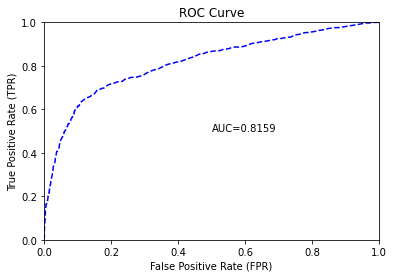

In [38]:
perf = best_xgb.model_performance(test)
perf.plot(type = "roc")

In [39]:
perf.auc()

0.8159001825821929

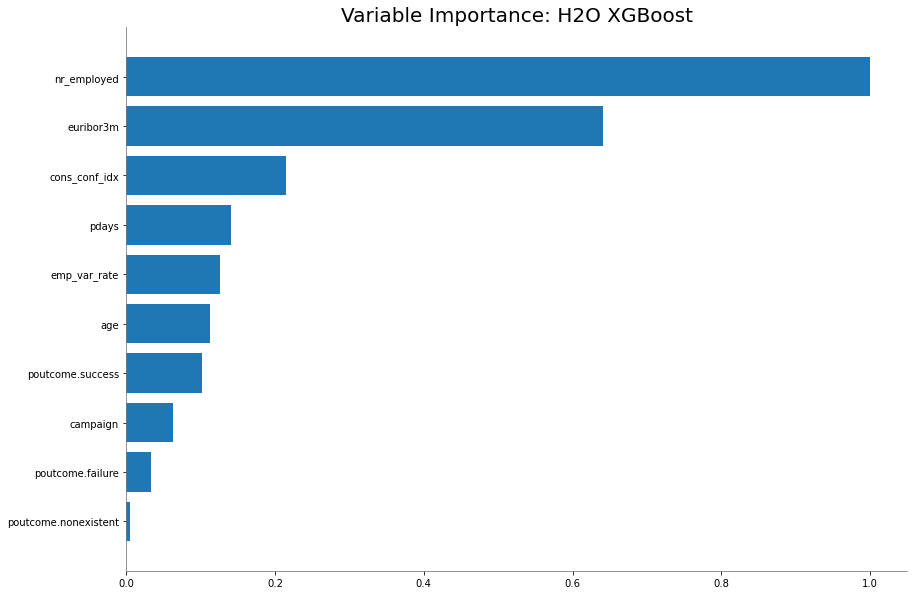

In [40]:
best_xgb.varimp_plot()
# Also try perf.varimp_plot()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


/Users/carsonransford/opt/anaconda3/lib/python3.8/site-packages/h2o/model/model_base.py:1724: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  if server: matplotlib.use("Agg", warn=False)



2D-PartialDependence: 2D Partial Dependence Plot of model XGBoost_model_1662824604267_6856 on 1st column 'nr_employed' and 2nd column 'y'


,nr_employed,y,mean_response,stddev_response,std_error_mean_response
0,4963.600000,FALSE,0.213937,0.123248,0.000726
1,4963.600000,TRUE,0.213937,0.123248,0.000726
2,4977.521053,FALSE,0.213937,0.123248,0.000726
3,4977.521053,TRUE,0.213937,0.123248,0.000726
4,4991.442105,FALSE,0.217753,0.123582,0.000728
5,4991.442105,TRUE,0.217753,0.123582,0.000728
6,5005.363158,FALSE,0.216028,0.123604,0.000728
7,5005.363158,TRUE,0.216028,0.123604,0.000728
8,5019.284211,FALSE,0.217147,0.121882,0.000718
9,5019.284211,TRUE,0.217147,0.121882,0.000718



See the whole table with table.as_data_frame()

2D-PartialDependence: 2D Partial Dependence Plot of model XGBoost_model_1662824604267_6856 on 1st column 'cons_conf_idx' and 2nd column 'y'


,cons_conf_idx,y,mean_response,stddev_response,std_error_mean_response
0,-50.800000,FALSE,0.199230,0.134281,0.000791
1,-50.800000,TRUE,0.199230,0.134281,0.000791
2,-49.542105,FALSE,0.205664,0.133552,0.000787
3,-49.542105,TRUE,0.205664,0.133552,0.000787
4,-48.284211,FALSE,0.155779,0.137304,0.000809
5,-48.284211,TRUE,0.155779,0.137304,0.000809
6,-47.026316,FALSE,0.156988,0.138563,0.000816
7,-47.026316,TRUE,0.156988,0.138563,0.000816
8,-45.768421,FALSE,0.116064,0.147788,0.000870
9,-45.768421,TRUE,0.116064,0.147788,0.000870



See the whole table with table.as_data_frame()

2D-PartialDependence: 2D Partial Dependence Plot of model XGBoost_model_1662824604267_6856 on 1st column 'euribor3m' and 2nd column 'y'


,euribor3m,y,mean_response,stddev_response,std_error_mean_response
0,0.634000,FALSE,0.162741,0.144131,0.000849
1,0.634000,TRUE,0.162741,0.144131,0.000849
2,0.866158,FALSE,0.165139,0.134993,0.000795
3,0.866158,TRUE,0.165139,0.134993,0.000795
4,1.098316,FALSE,0.144051,0.116339,0.000685
5,1.098316,TRUE,0.144051,0.116339,0.000685
6,1.330474,FALSE,0.101058,0.113285,0.000667
7,1.330474,TRUE,0.101058,0.113285,0.000667
8,1.562632,FALSE,0.137919,0.121283,0.000714
9,1.562632,TRUE,0.137919,0.121283,0.000714



See the whole table with table.as_data_frame()

2D-PartialDependence: 2D Partial Dependence Plot of model XGBoost_model_1662824604267_6856 on 1st column 'emp_var_rate' and 2nd column 'y'


,emp_var_rate,y,mean_response,stddev_response,std_error_mean_response
0,-3.400000,FALSE,0.249027,0.151096,0.000890
1,-3.400000,TRUE,0.249027,0.151096,0.000890
2,-3.147368,FALSE,0.251024,0.151634,0.000893
3,-3.147368,TRUE,0.251024,0.151634,0.000893
4,-2.894737,FALSE,0.251024,0.151634,0.000893
5,-2.894737,TRUE,0.251024,0.151634,0.000893
6,-2.642105,FALSE,0.251024,0.151634,0.000893
7,-2.642105,TRUE,0.251024,0.151634,0.000893
8,-2.389474,FALSE,0.251024,0.151634,0.000893
9,-2.389474,TRUE,0.251024,0.151634,0.000893



See the whole table with table.as_data_frame()


[, , , ]

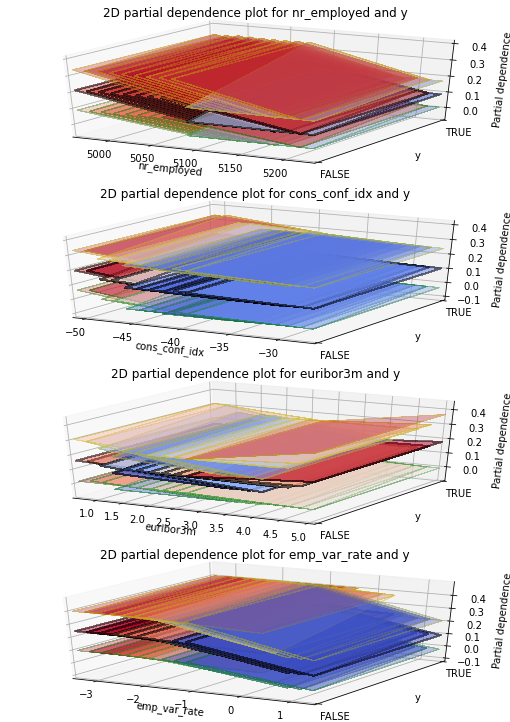

In [44]:
# 'poutcome', 'age', 'campaign', 'pdays',
#        'emp_var_rate', 'cons_conf_idx', 'euribor3m', 'nr_employed'
    
best_xgb.partial_plot(data = train,
                                  server = True,
                                  plot = True,
                                  col_pairs_2dpdp = [['nr_employed', 'y'],['cons_conf_idx', 'y'], ['euribor3m', 'y'], ['emp_var_rate', 'y']])

In [97]:
h2o.shutdown(prompt = False)

<ipython-input-97-b3a1aba4ba88>:1: DeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown(prompt = False)


H2O session _sid_80e8 closed.
